Library imports

In [1]:
import rasterio
import seaborn as sns
from shapely import wkt
import pandas as pd

import utilities as utils

Loads the datacube

In [2]:
data = utils.load_dataset('data/2021_Table04_Datacube.csv')
data.head()

ï»¿"H3_Address"  H3_Resolution  \
0  8712e579bffffff              7   
1  8712e579affffff              7   
2  8712e56b4ffffff              7   
3  8712e56b5ffffff              7   
4  8712e56a6ffffff              7   

                                         H3_Geometry  Longitude_EPSG4326  \
0  POLYGON ((-115.0314 54.5077, -115.0393 54.4961...         -115.018142   
1  POLYGON ((-115.0658 54.51706, -115.0737 54.505...         -115.052542   
2  POLYGON ((-115.0604 54.49501, -115.0682 54.483...         -115.047107   
3  POLYGON ((-115.026 54.48564, -115.0338 54.4740...         -115.012729   
4  POLYGON ((-114.997 54.49832, -115.0049 54.4867...         -114.983753   

   Latitude_EPSG4326 Continent_Majority Continent_Minority Country_Majority  \
0          54.497221      North America      North America           Canada   
1          54.506590      North America      North America           Canada   
2          54.484541      North America      North America           Canada   
3          54.475169      North America      North America           Canada   
4          54.487840      North America      North America           Canada   

  Country_Minority Province_Majority  ... Litmod_Density_Asthenosphere  \
0           Canada           Alberta  ...                  3480.580078   
1           Canada           Alberta  ...                  3480.580078   
2           Canada           Alberta  ...                  3480.580078   
3           Canada           Alberta  ...                  3480.580078   
4           Canada           Alberta  ...                  3480.580078   

  Litmod_Density_Crust Litmod_Density_Lithosphere Crust1_Type  \
0          2891.260254                3337.300049  island arc   
1          2891.260010                3337.300293  island arc   
2          2891.259766                3337.300049  island arc   
3          2891.260010                3337.300049  island arc   
4          2891.260010                3337.300049  island arc   

   Crust1_CrustalThickness Crust1_SedimentThickness Training_MVT_Deposit  \
0               -38.450497              2991.459961               Absent   
1               -38.430000              3000.000244               Absent   
2               -38.430000              3000.000000               Absent   
3               -38.591599              2932.666504               Absent   
4               -39.815273              2422.801758               Absent   

  Training_MVT_Occurrence Training_CD_Deposit Training_CD_Occurrence  
0                  Absent              Absent                 Absent  
1                  Absent              Absent                 Absent  
2                  Absent              Absent                 Absent  
3                  Absent              Absent                 Absent  
4                  Absent              Absent                 Absent  

[5 rows x 97 columns]

In [3]:
# modifies presence / absence columns to boolean - geology properties
data["Geology_Dictionary_Alkalic"] = data["Geology_Dictionary_Alkalic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Anatectic"] = data["Geology_Dictionary_Anatectic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Calcareous"] = data["Geology_Dictionary_Calcareous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Carbonaceous"] = data["Geology_Dictionary_Carbonaceous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Cherty"] = data["Geology_Dictionary_Cherty"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_CoarseClastic"] = data["Geology_Dictionary_CoarseClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Evaporitic"] = data["Geology_Dictionary_Evaporitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Felsic"] = data["Geology_Dictionary_Felsic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_FineClastic"] = data["Geology_Dictionary_FineClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Gneissose"] = data["Geology_Dictionary_Gneissose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Igneous"] = data["Geology_Dictionary_Igneous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Intermediate"] = data["Geology_Dictionary_Intermediate"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Pegmatitic"] = data["Geology_Dictionary_Pegmatitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_RedBed"] = data["Geology_Dictionary_RedBed"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Schistose"] = data["Geology_Dictionary_Schistose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Sedimentary"] = data["Geology_Dictionary_Sedimentary"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_UltramaficMafic"] = data["Geology_Dictionary_UltramaficMafic"].apply(lambda x: True if x == "Present" else False)
# modifies presence / absence columns to boolean - labels
data["Training_MVT_Deposit"] = data["Training_MVT_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_MVT_Occurrence"] = data["Training_MVT_Occurrence"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Deposit"] = data["Training_CD_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Occurrence"] = data["Training_CD_Occurrence"].apply(lambda x: True if x == "Present" else False)

Selects the data /labels used for MVT WOE baseline

In [4]:
cols_dict = utils.load_features_dict(type='MVT', baseline='baseline')
data_filtered, cols = utils.extract_cols(data, cols_dict)

data_filtered_aus = data_filtered[data_filtered["Continent_Majority"] == "Oceania"]
data_filtered_uscan = data_filtered[data_filtered["Continent_Majority"] == "North America"]

The following function finds all the neighbors and creates a new column "MVT_Deposit".
Original paper treats neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" as mineral present, "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor). 

In [5]:
data_filtered_aus = utils.neighbor_deposits(data_filtered_aus, type='MVT')
data_filtered_uscan = utils.neighbor_deposits(data_filtered_uscan, type='MVT')

/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{type}_Deposit'] = df.apply(lambda row: True if True in [row[f'Training_{type}_Deposit'], row[f'Training_{type}_Occurrence']] else False, axis=1)
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['H3_Geometry2'] = df['H3_Geometry'].apply(lambda x: x[10:-2].split(', ')[:-1])
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:237: Sett

In [6]:
labels_filtered_aus = data_filtered_aus['MVT_Deposit_wNeighbors']
geometry_filtered_aus = data_filtered_aus["H3_Geometry"]
continent_filtered_aus = data_filtered_aus["Continent_Majority"]

labels_filtered_uscan = data_filtered_uscan['MVT_Deposit_wNeighbors']
geometry_filtered_uscan = data_filtered_uscan["H3_Geometry"]
continent_filtered_uscan = data_filtered_uscan["Continent_Majority"]

data_filtered_aus = data_filtered_aus.drop(columns=['H3_Geometry', 'Continent_Majority', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
data_filtered_uscan = data_filtered_uscan.drop(columns=['H3_Geometry', 'Continent_Majority', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])

cols = cols[2:-2]

Clearly the dataset has MANY outliers, as reported in the paper

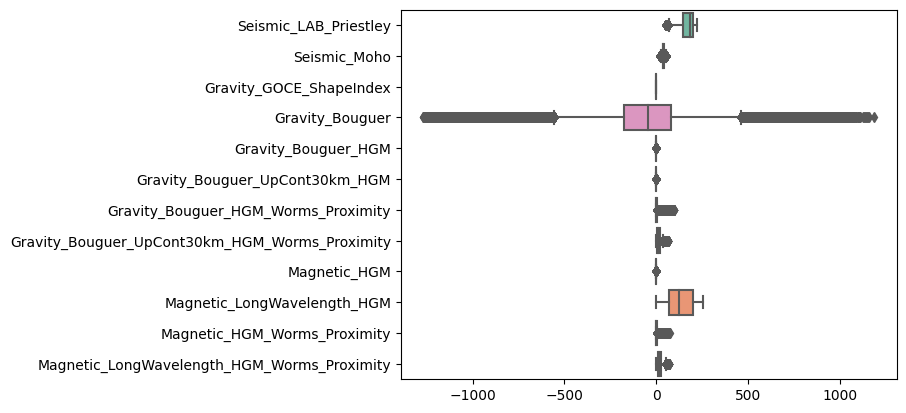

In [7]:
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

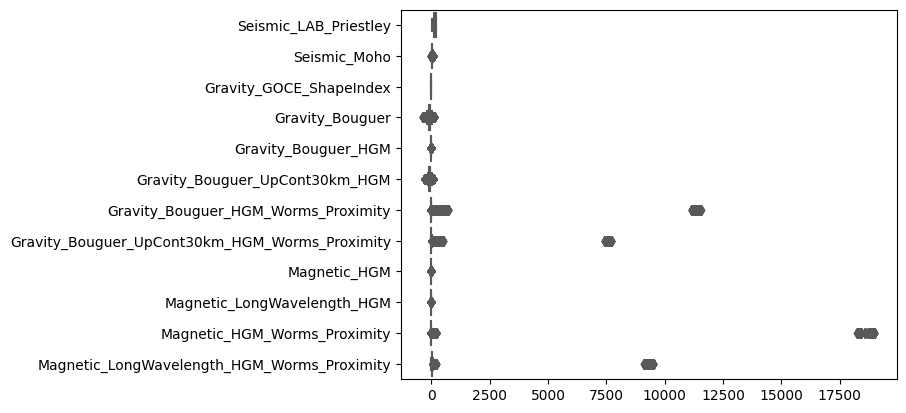

In [8]:
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

We can remove these outliers

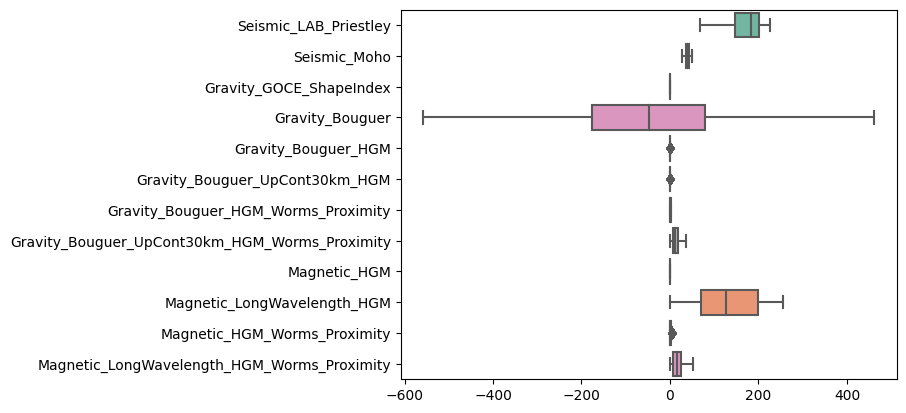

In [9]:
data_filtered_aus = utils.tukey_remove_outliers(data_filtered_aus)
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

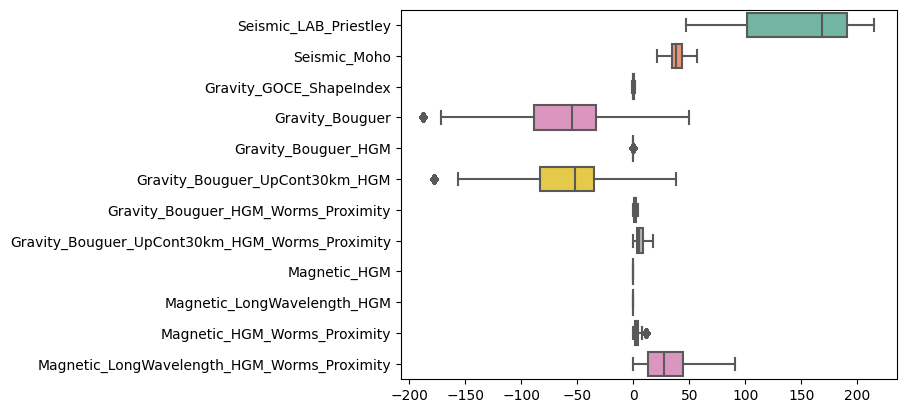

In [10]:
data_filtered_uscan = utils.tukey_remove_outliers(data_filtered_uscan)
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [11]:
print(data_filtered_aus.isna().sum())

Seismic_LAB_Priestley                               0
Seismic_Moho                                        0
Gravity_GOCE_ShapeIndex                             0
Gravity_Bouguer                                     0
Gravity_Bouguer_HGM                                 0
Gravity_Bouguer_UpCont30km_HGM                      0
Gravity_Bouguer_HGM_Worms_Proximity                 0
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity      0
Magnetic_HGM                                      158
Magnetic_LongWavelength_HGM                       169
Magnetic_HGM_Worms_Proximity                        0
Magnetic_LongWavelength_HGM_Worms_Proximity         0
dtype: int64


In [12]:
print(data_filtered_uscan.isna().sum())

Seismic_LAB_Priestley                                  0
Seismic_Moho                                        1266
Gravity_GOCE_ShapeIndex                                0
Gravity_Bouguer                                    36359
Gravity_Bouguer_HGM                                36403
Gravity_Bouguer_UpCont30km_HGM                     36385
Gravity_Bouguer_HGM_Worms_Proximity                    0
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity         0
Magnetic_HGM                                      136464
Magnetic_LongWavelength_HGM                       136652
Magnetic_HGM_Worms_Proximity                           0
Magnetic_LongWavelength_HGM_Worms_Proximity            0
dtype: int64


In [13]:
data_filtered_aus = utils.impute_nans(data_filtered_aus)
print(data_filtered_aus.isna().sum())

Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity    0
Magnetic_HGM                                      0
Magnetic_LongWavelength_HGM                       0
Magnetic_HGM_Worms_Proximity                      0
Magnetic_LongWavelength_HGM_Worms_Proximity       0
dtype: int64


In [14]:
data_filtered_uscan = utils.impute_nans(data_filtered_uscan)
print(data_filtered_uscan.isna().sum())

Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity    0
Magnetic_HGM                                      0
Magnetic_LongWavelength_HGM                       0
Magnetic_HGM_Worms_Proximity                      0
Magnetic_LongWavelength_HGM_Worms_Proximity       0
dtype: int64


Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


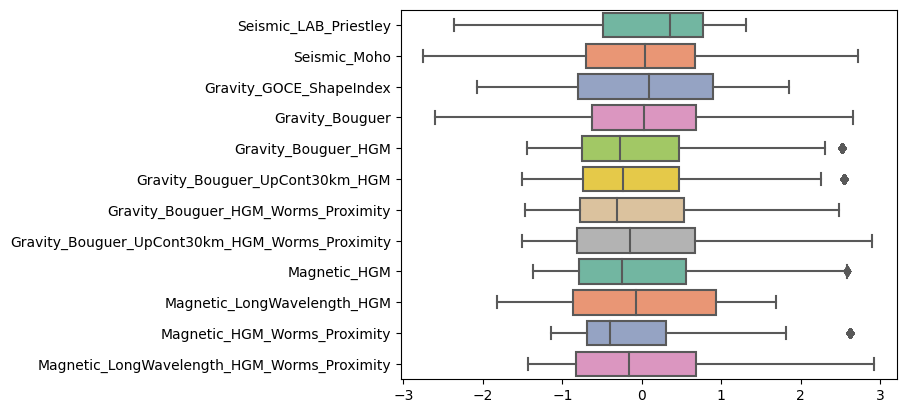

In [15]:
data_filtered_aus = utils.normalize_df(data_filtered_aus)
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


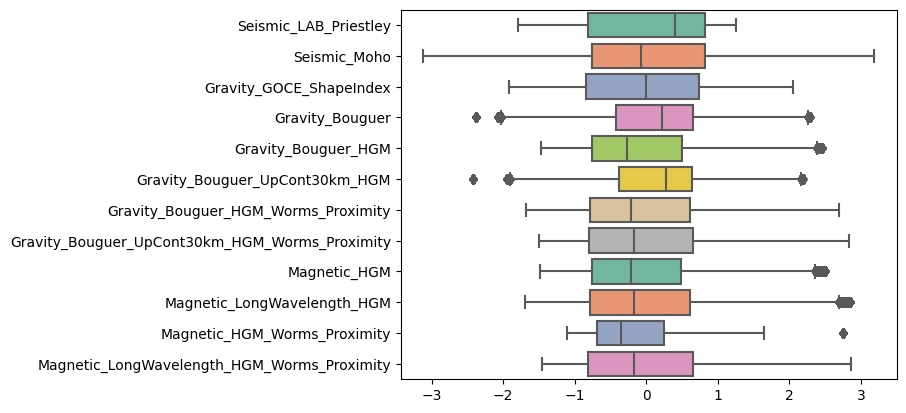

In [16]:
data_filtered_uscan = utils.normalize_df(data_filtered_uscan)
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

Adds back the labels, geometry, and continent

In [17]:
data_filtered_aus["target"] = labels_filtered_aus
data_filtered_aus["H3_Geometry"] = geometry_filtered_aus
data_filtered_aus["Continent_Majority"] = continent_filtered_aus

data_filtered_uscan["target"] = labels_filtered_uscan
data_filtered_uscan["H3_Geometry"] = geometry_filtered_uscan
data_filtered_uscan["Continent_Majority"] = continent_filtered_uscan

In [18]:
data_filtered = pd.concat((data_filtered_aus, data_filtered_uscan), ignore_index=True)
data_filtered.reset_index(drop=True, inplace=True)
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164833 entries, 0 to 5164832
Data columns (total 15 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   Seismic_LAB_Priestley                           float64
 1   Seismic_Moho                                    float64
 2   Gravity_GOCE_ShapeIndex                         float64
 3   Gravity_Bouguer                                 float64
 4   Gravity_Bouguer_HGM                             float64
 5   Gravity_Bouguer_UpCont30km_HGM                  float64
 6   Gravity_Bouguer_HGM_Worms_Proximity             float64
 7   Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity  float64
 8   Magnetic_HGM                                    float64
 9   Magnetic_LongWavelength_HGM                     float64
 10  Magnetic_HGM_Worms_Proximity                    float64
 11  Magnetic_LongWavelength_HGM_Worms_Proximity     float64
 12  target                      

Generates tiff files for every column, separate for US/Canada and Australia

/tmp/ipykernel_25044/3219266524.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube.rename({


Rasterizing Oceania


  0%|          | 0/13 [00:00<?, ?it/s]

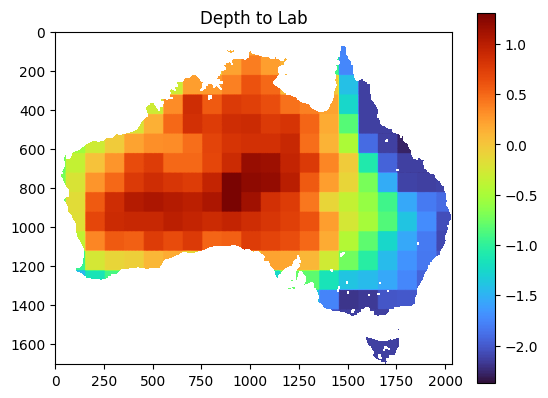

  8%|▊         | 1/13 [01:14<14:51, 74.25s/it]

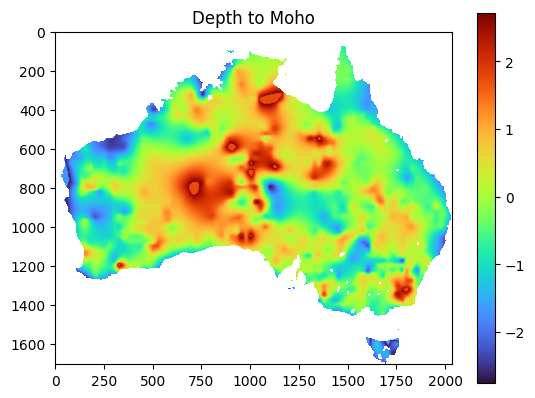

 15%|█▌        | 2/13 [02:28<13:33, 73.99s/it]

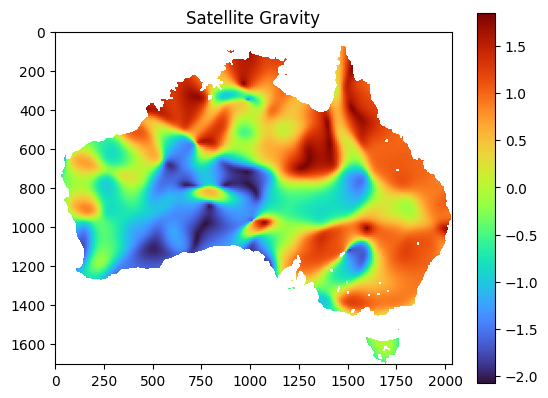

 23%|██▎       | 3/13 [03:42<12:21, 74.17s/it]

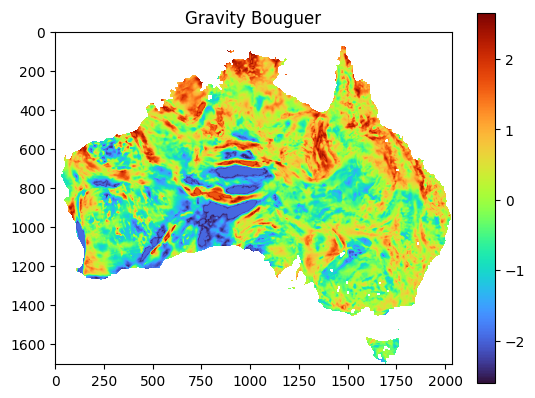

 31%|███       | 4/13 [04:56<11:06, 74.00s/it]

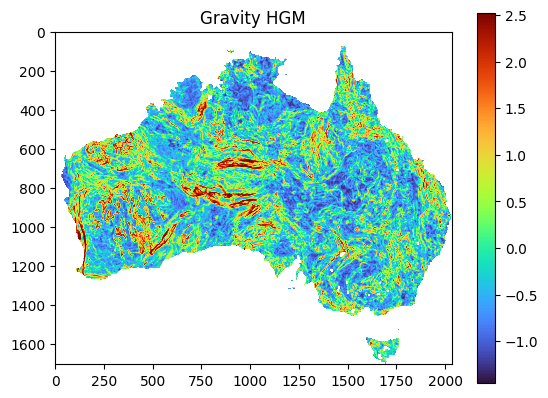

 38%|███▊      | 5/13 [06:10<09:53, 74.18s/it]

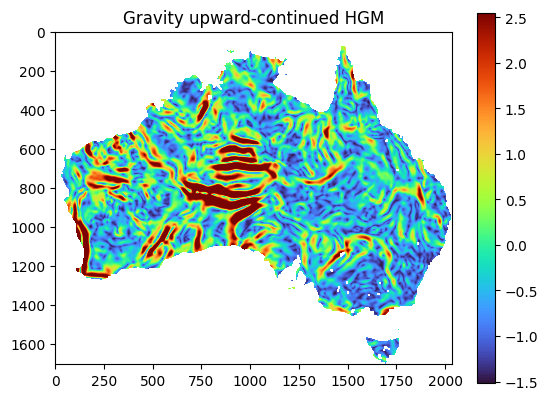

 46%|████▌     | 6/13 [07:24<08:37, 74.00s/it]

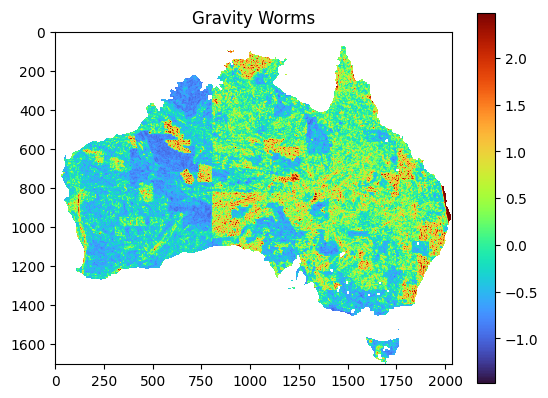

 54%|█████▍    | 7/13 [08:38<07:23, 73.93s/it]

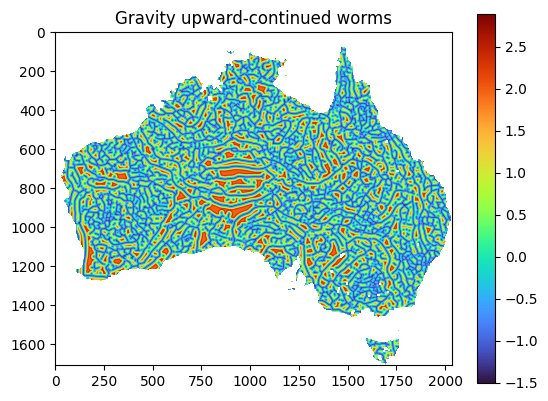

 62%|██████▏   | 8/13 [09:54<06:14, 74.82s/it]

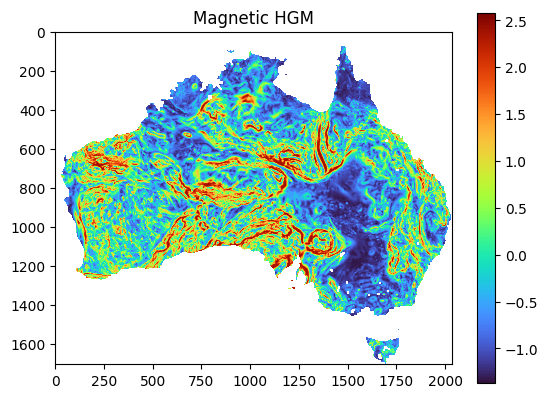

 69%|██████▉   | 9/13 [11:09<04:58, 74.70s/it]

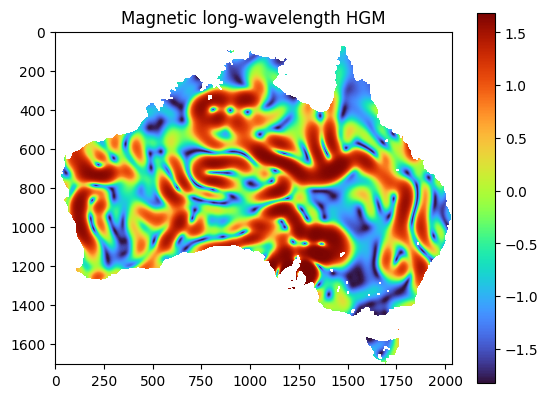

 77%|███████▋  | 10/13 [12:22<03:43, 74.39s/it]

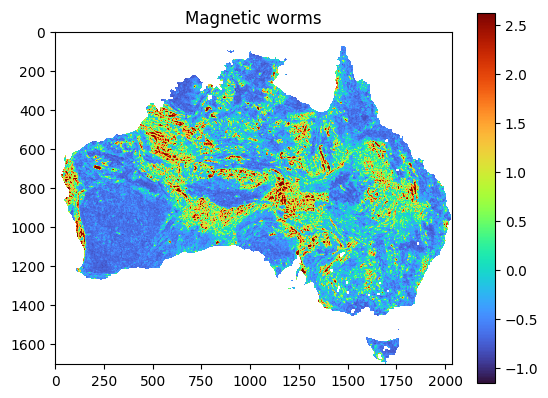

 85%|████████▍ | 11/13 [13:36<02:28, 74.10s/it]

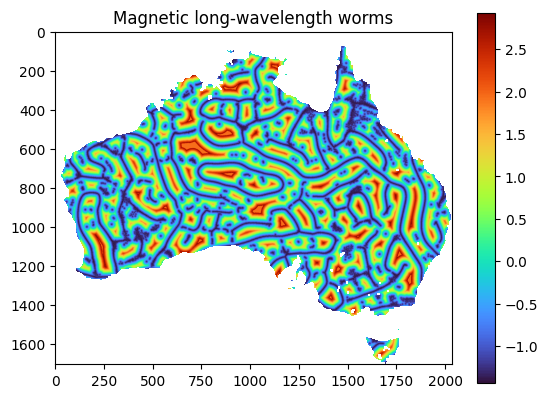

 92%|█████████▏| 12/13 [14:50<01:14, 74.00s/it]

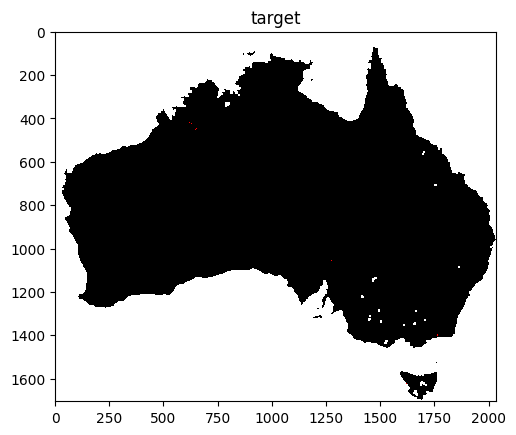

100%|██████████| 13/13 [15:57<00:00, 73.66s/it]


Rasterizing North America


/tmp/ipykernel_25044/3219266524.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube.rename({
  0%|          | 0/13 [00:00<?, ?it/s]

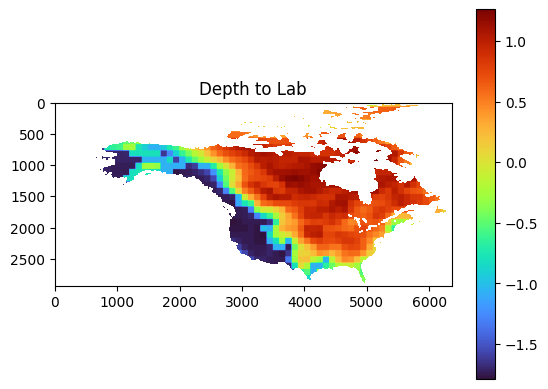

  8%|▊         | 1/13 [02:54<34:53, 174.50s/it]

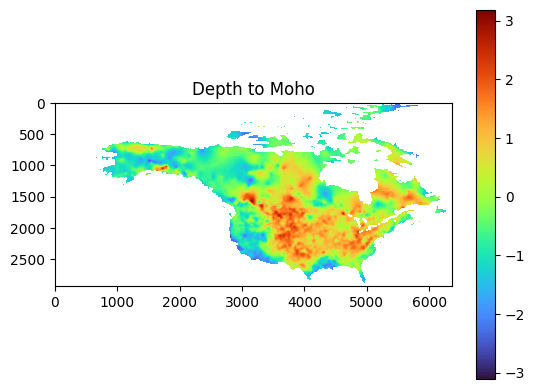

 15%|█▌        | 2/13 [05:50<32:09, 175.37s/it]

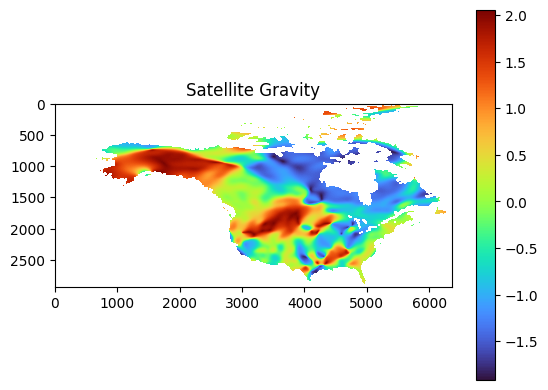

 23%|██▎       | 3/13 [08:43<29:02, 174.23s/it]

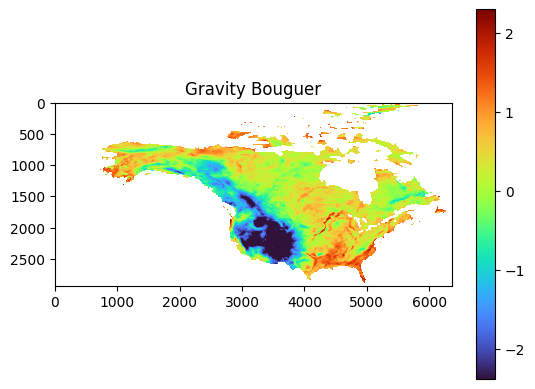

 31%|███       | 4/13 [11:38<26:12, 174.76s/it]

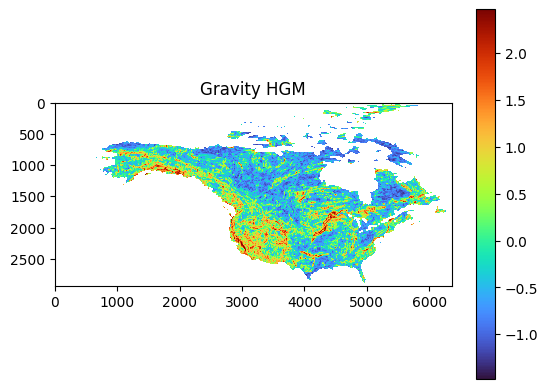

 38%|███▊      | 5/13 [14:35<23:22, 175.36s/it]

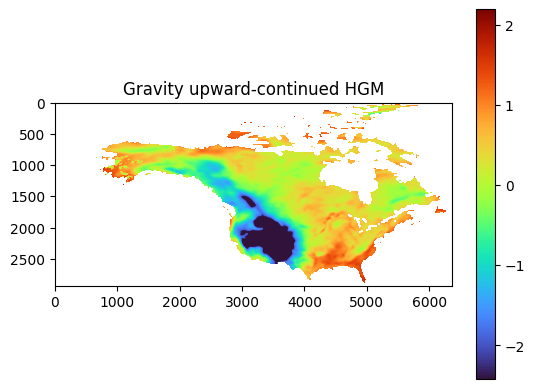

 46%|████▌     | 6/13 [17:29<20:23, 174.84s/it]

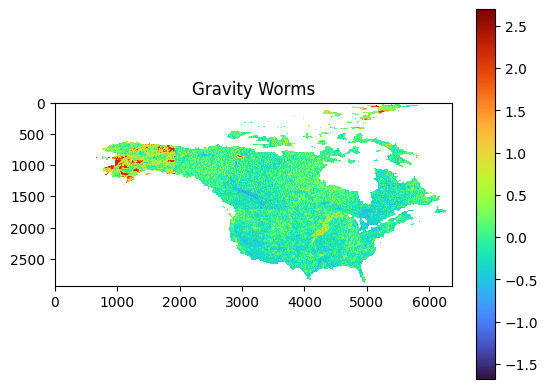

 54%|█████▍    | 7/13 [20:24<17:29, 174.95s/it]

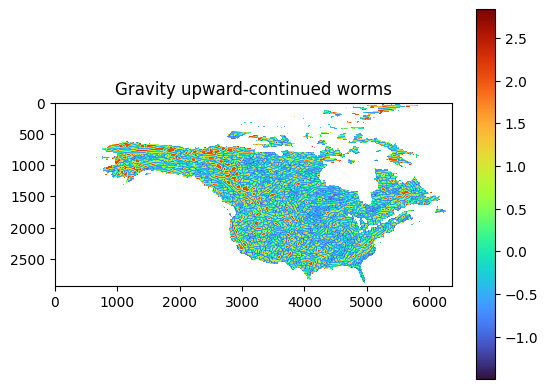

 62%|██████▏   | 8/13 [23:17<14:32, 174.52s/it]

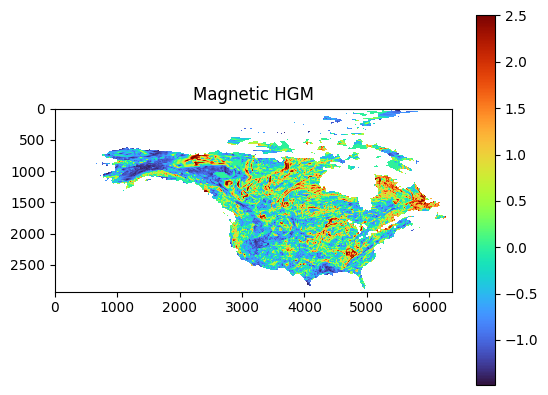

 69%|██████▉   | 9/13 [26:12<11:38, 174.65s/it]

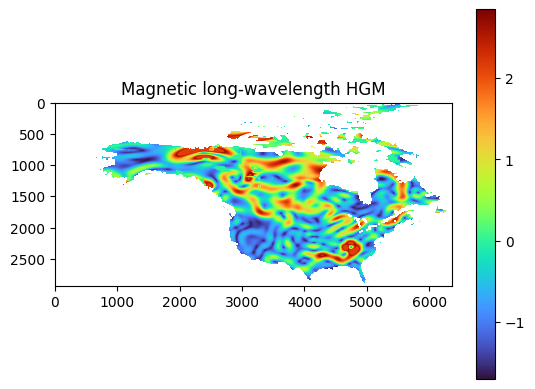

 77%|███████▋  | 10/13 [29:07<08:44, 174.70s/it]

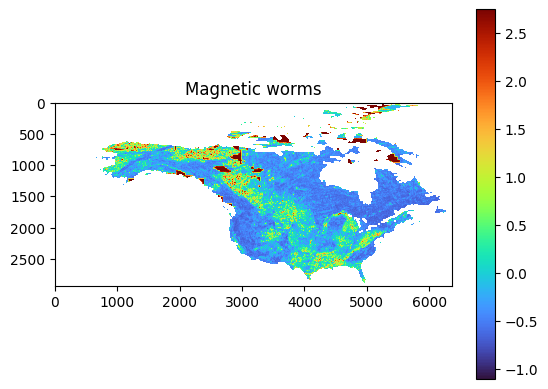

 85%|████████▍ | 11/13 [32:03<05:50, 175.16s/it]

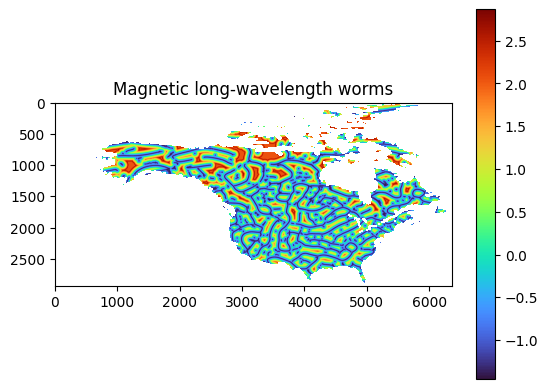

 92%|█████████▏| 12/13 [34:59<02:55, 175.23s/it]

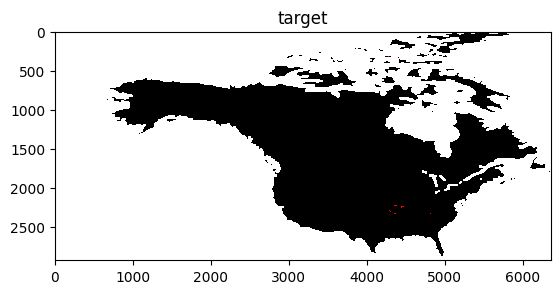

100%|██████████| 13/13 [37:48<00:00, 174.54s/it]


In [19]:
continents = {
    "Oceania": {'left':112.9, 'bottom':-43.6, 'right':153.6, 'top':-9.5},
    "North America": {'left':-179.8, 'bottom':24.5, 'right':-52.6, 'top':83.15}
}

resolution = (0.02, 0.02)

data_filtered["H3_Geometry"] = data_filtered["H3_Geometry"].apply(wkt.loads)

nodata_value = rasterio.open("./data2/GeophysicsGravity_Australia.tif").nodata

for idx, (continent, bounds) in enumerate(continents.items()):
    print(f"Rasterizing {continent}")
    continent_datacube = data_filtered[data_filtered["Continent_Majority"] == continent]

    height = int((bounds["top"]-bounds["bottom"]) / resolution[0])
    width = int((bounds["right"]-bounds["left"]) / resolution[1])

    tif_tf = rasterio.transform.from_bounds(
        bounds["left"],
        bounds["bottom"],
        bounds["right"],
        bounds["top"],
        width,
        height
    )

    tiff_meta = {
        "driver": 'GTiff',
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float64",
        "crs": rasterio.CRS.from_epsg(4326),
        "transform": tif_tf,
        "nodata": nodata_value,
        "compress": "lzw",
    }

    continent_datacube.rename({
        # geology
        # "Geology_Lithology_Majority": "Lithology (major)",
        # "Geology_Period_Maximum_Majority": "Period (maximum)",
        # "Geology_Period_Minimum_Majority": "Period (minimum)",
        # "Geology_Paleolatitude_Period_Maximum": "Paleo-latitude",
        # "Terrane_Proximity": "Proximity to terrane boundaries",
        # "Geology_PassiveMargin_Proximity": "Proximity to passive margins",
        # "Geology_BlackShale_Proximity": "Proximity to black shales",
        # "Geology_Fault_Proximity": "Proximity to faults",
        # "Sedimentary_Dictionary": "Sedimentary dictionaries",
        # "Igneous_Dictionary": "Igneous dictionaries",
        # "Metamorphic_Dictionary": "Metamorphic dictionaries",
        # geophysics
        "Seismic_LAB_Priestley": "Depth to Lab",
        "Seismic_Moho": "Depth to Moho",
        "Gravity_GOCE_ShapeIndex": "Satellite Gravity",
        "Gravity_Bouguer": "Gravity Bouguer",
        "Gravity_Bouguer_HGM": "Gravity HGM",
        "Gravity_Bouguer_UpCont30km_HGM": "Gravity upward-continued HGM",
        "Gravity_Bouguer_HGM_Worms_Proximity": "Gravity Worms",
        "Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity": "Gravity upward-continued worms",
        "Magnetic_HGM": "Magnetic HGM",
        "Magnetic_LongWavelength_HGM": "Magnetic long-wavelength HGM",
        "Magnetic_HGM_Worms_Proximity": "Magnetic worms",
        "Magnetic_LongWavelength_HGM_Worms_Proximity": "Magnetic long-wavelength worms"
    }, axis=1, inplace=True)
    
    utils.visualize_datacube(continent_datacube, tiff_meta)

    utils.rasterize_datacube(continent_datacube, tiff_meta, './data2/', "lawley_"+continent.lower().replace(" ","-"))